# main.ipynb

**Main driver for advection, hydrodynamics (HD), and magnetohydrodynamics (MHD) simulations in 2D (X,Y) Cartesian and Cylindrical axisymmetric (R,Z) geometries.**

This notebook handles:
- Grid construction  
- Initial condition setup  
- Solver selection  
- Simulation control loop  
- Optional visualization  

---

## Available Modes
- **`'adv'`** : Linear advection problems  
- **`'HD'`**  : Hydrodynamics problems  
- **`'MHD'`** : Magnetohydrodynamics problems  

---

## Available Problems

### Advection (see `advection_init_cond.py`)
- `smooth1D` : IC_advection1D_smooth  
- `disc1D`   : IC_advection1D_disc  
- `smooth2D` : IC_advection2D_smooth  
- `disc2D`   : IC_advection2D_disc  
- `user_defined` : IC_advection_user_defined  

### Hydrodynamics (see `hydro_init_cond.py`)
- `sod1Dcart` : IC_hydro1D_Sod(cartesian)  
- `sod1Dcyl`  : IC_hydro1D_Sod(cylindrical)  
- `sod1Dpol`  : IC_hydro1D_Sod(polar)  
- `strong1D`  : IC_hydro1D_strong_shock  
- `DBW1D`     : IC_hydro1D_DBW  
- `KHI`       : IC_hydro2D_KHI  
- `RTI`       : IC_hydro2D_RTI  
- `sod2Dcart` : IC_hydro2D_Sod  
- `sedov2Dcart` : IC_hydro2D_Sedov_cart  
- `sedov2Dcyl`  : IC_hydro2D_Sedov_cyl  
- `user_defined` : IC_hydro_user_defined  

### Magnetohydrodynamics (see `MHD_init_cond.py`)
- `BW1D`       : IC_MHD1D_BW  
- `toth1D`     : IC_MHD1D_Toth  
- `blast-cart` : IC_MHD2D_blast_cart  
- `blast-cyl`  : IC_MHD2D_blast_cyl  
- `OT2D`       : IC_MHD2D_OT  
- `user_defined` : IC_MHD_user_defined  

---

## Parameters (`Parameters` class)

- **mode**       : `str` – Simulation type (`'adv'`, `'HD'`, `'MHD'`)  
- **problem**    : `str` – Problem name (depends on mode)  
- **Nx1, Nx2**   : `int` – Grid resolution  
- **flux_type**  : `str` – Flux solver (`'adv'`, `'HLLC'`, `'HLLD'`, etc.)  
- **divb_tr**    : `str` – Divergence cleaning method (`'CT'`, `'8wave'`) *(MHD only)*  
- **rec_type**   : `str` – Reconstruction method (`'PLM'`, `'PPM'`, `'WENO'`, etc.)  
- **RK_order**   : `str` – Runge-Kutta order (`'RK1'`, `'RK2'`, `'RK3'`)  
- **CFL**        : `float` – CFL stability number  
- **timefin**    : `float` – Final physical time  
- **timenow**    : `float` – Current physical time  

---

## Available Parameters

### All modes
- **Required**:
  - `mode` (str)  
  - `problem` (str)  
  - `Nx1, Nx2` (int)  
- **Optional**:
  - `CFL` (float < 1)  
  - `rec_type` = `'PLM'`, `'PPM'`, `'PCM'`, `'PPMorig'`, `'WENO'`  
  - `RK_order` = `'RK1'`, `'RK2'`, `'RK3'`  

### Advection
- `flux_type` = `'adv'`, `'LW'`  

### Hydrodynamics
- `flux_type` = `'LLF'`, `'HLL'`, `'HLLC'`, `'Roe'`  

### Magnetohydrodynamics
- `flux_type` = `'LLF'`, `'HLL'`, `'HLLD'`  
- `divb_tr` = `'CT'`, `'8wave'`  
- `CFL` < 1  

---

**Author:** mrkondratyev

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

from grid_setup import Grid
from sim_state import SimState
from parameters import Parameters
from MHD_one_step_CT import MHD2D_CT
from MHD_one_step_8wave import MHD2D_8wave
from hydro_one_step import Hydro2D
from advection_one_step import Advection2D
from helpers import run_simulation, initial_model
from visualization import plot_setup


## Solver Dispatch Dictionary
This replaces long `if/elif` blocks with a clean lookup.


In [3]:
SOLVER_DISPATCH = {
    "adv": lambda grid, state, eos, par: Advection2D(grid, state, par),
    "HD":  lambda grid, state, eos, par: Hydro2D(grid, state, eos, par),
    "MHD": lambda grid, state, eos, par: (
        MHD2D_CT(grid, state, eos, par)
        if par.divb_tr == "CT" else
        MHD2D_8wave(grid, state, eos, par)
    ),
}


## Define Simulation Parameters
You can edit these interactively and re-run.


In [33]:
par = Parameters(
    mode="MHD",          # "adv", "HD", or "MHD"
    problem="user_defined",# problem type
    Nx1=64,              # grid resolution x1
    Nx2=128,              # grid resolution x2
    rec_type='PPM',      # reconstruction type
    RK_order='RK3',      # Runge-Kutta order
    flux_type="HLL",    # flux solver
    divb_tr='CT',     # divergence control: "CT" or "8wave", MHD only 
)

print(par)  # display configuration


Simulation mode   : MHD
Problem           : user_defined
Resolution        : Nx1=64, Nx2=128, Ngc=3
Reconstruction    : PPM
RK Order          : RK3
Flux Type         : HLL
CFL               : 0.7
divB treatment    : CT


## Initialize Grid and simulated State


In [34]:
grid = Grid(par.Nx1, par.Nx2, par.Ngc)
simstate = SimState(grid, par)
grid, simstate, par, eos = initial_model(grid, simstate, par)


user-defined problem for MHD


ValueError: User-defined MHD problem, see file 'MHD_init_cond.py'.

## Select Solver


In [28]:
solver = SOLVER_DISPATCH[par.mode](grid, simstate, eos, par)


## Run Simulation


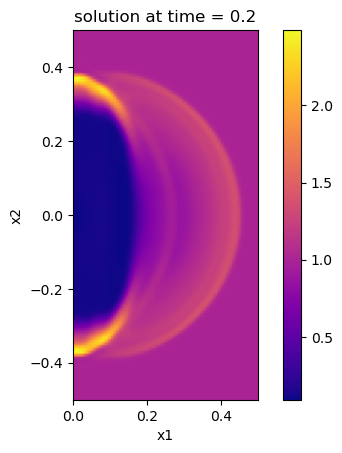

final phys time =  0.2
END OF SIMULATION
elapsed time =  5.397989749908447  secs


In [29]:
#number of timesteps for visualisation
nsteps_visual = 100

simstate, par.timenow = run_simulation(
    grid, simstate, par, solver, simstate.dens, nsteps_visual
)


## Visualization (Optional)


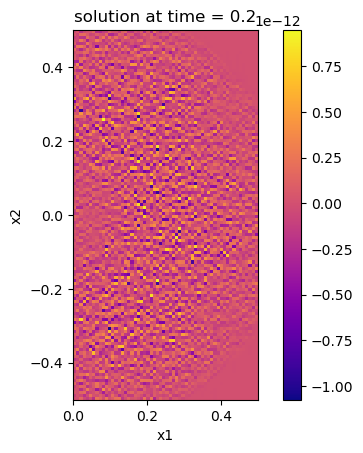

In [30]:
if par.mode == "MHD":
    line, ax, fig, im = plot_setup(grid, simstate.divB, par.timenow)
    plt.show()
